In [5]:
import numpy as np
#import os
#import six.moves.urllib as urllib
import sys
#import tarfile
import tensorflow as tf
#import zipfile

#from distutils.version import StrictVersion
#from collections import defaultdict
#from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

In [6]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [7]:
%matplotlib inline

In [8]:
from utils import label_map_util

from utils import visualization_utils as vis_util

In [9]:
MODEL_NAME = 'inference_graphew'
DOWNLOAD_BASE=''
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = 'training_fcnn/labelmap.pbtxt'

In [10]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [11]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [12]:
category_index

{1: {'id': 1, 'name': 'Investor'},
 2: {'id': 2, 'name': 'Fund'},
 3: {'id': 3, 'name': 'Date'},
 4: {'id': 4, 'name': 'EMV'}}

In [13]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [14]:
import os

In [15]:
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 4) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [16]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
        if 'detection_masks' in tensor_dict:
            # The following processing is only for single image
            detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
            detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
            # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
            real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
            detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
            detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
            detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                detection_masks, detection_boxes, image.shape[1], image.shape[2])
            detection_masks_reframed = tf.cast(
                tf.greater(detection_masks_reframed, 0.5), tf.uint8)
            print(real_num_detection)
            # Follow the convention by adding back the batch dimension
            tensor_dict['detection_masks'] = tf.expand_dims(
                detection_masks_reframed, 0)


      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      #print(output_dict['num_detections'])
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [17]:
import tkinter
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

In [18]:
# D:\projects_python\prakesh\Invoices_ F\FedEx\FedEx_Page_1.jpg

In [19]:
image = cv2.imread(r"C:\Users\malini.d\Desktop\net_scholar\Train_images\image_name12.jpg")
image_np_expanded = np.expand_dims(image, axis=0)
output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)

In [20]:
# suppressed = tf.image.non_max_suppression(output_dict['detection_boxes'], output_dict['detection_scores'], 2) # Replace 5 with max num desired boxes


# sboxes = tf.gather(output_dict['detection_boxes'], suppressed)
# sscores = tf.gather(output_dict['detection_scores'], suppressed)
# sclasses = tf.gather(output_dict['detection_classes'], suppressed)

# sess = tf.Session()
# with sess.as_default():
#     boxes = sboxes.eval()
#     scores =sscores.eval()
#     classes = sclasses.eval()

# vis_util.visualize_boxes_and_labels_on_image_array(
#       image,
#       boxes,
#       classes,
#       scores,
#       category_index,
#       instance_masks=output_dict.get('detection_masks'),
#       use_normalized_coordinates=True,
#       line_thickness=2)
# import imutils
# image=imutils.resize(image,(800))
# cv2.imshow('cropped image', image)
# cv2.waitKey(0)

# #plt.figure(figsize=IMAGE_SIZE)
# plt.imshow(image)
# plt.show()

In [21]:

# img_height, img_width, img_channel = image.shape

In [22]:
# absolute_coord = []
# THRESHOLD = 0.7 # adjust your threshold here
# N = len(output_dict['detection_boxes'])
# for i in range(N):
#     if output_dict['detection_scores'][i] < THRESHOLD:
#         continue
#     box = output_dict['detection_boxes']
#     box = ymin, xmin, ymax, xmax 
#     x_up = int(xmin*img_width)
#     y_up = int(ymin*img_height)
#     x_down = int(xmax*img_width)
#     y_down = int(ymax*img_height)
#     absolute_coord.append((x_up,y_up,x_down,y_down))

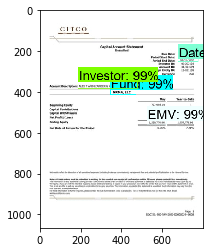

In [24]:
image = cv2.imread(r"C:\Users\malini.d\Desktop\net_scholar\Train_images\image_name88.jpg")
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
#image_np = load_image_into_numpy_array(image)
  #Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image, axis=0)
  # Actual detection.
output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
        image,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True, 
        line_thickness=1)
# print(output_dict['detection_boxes'])
import imutils
image=imutils.resize(image,(800))
cv2.imshow('cropped image', image)
cv2.waitKey(0)

#plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image)
plt.show()

In [ ]:
# import imutils
# image=imutils.resize(image,(600))
# cv2.imshow('cropped image', image)
# cv2.waitKey(0)

In [ ]:
# pip install imutils

In [ ]:
# pip install pytesseract

In [ ]:
# import cv2
# import numpy as np
# import tensorflow as tf
# from matplotlib import pyplot as plt
# from PIL import Image
# from object_detection.utils import ops as utils_ops
# from utils import label_map_util
# from utils import visualization_utils as vis_util
# import pytesseract

In [ ]:
# MODEL_NAME = 'inference_graphew'
# DOWNLOAD_BASE=''
# PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
# PATH_TO_LABELS = 'training/labelmap.pbtxt'

In [ ]:
# sess = tf.Session(graph=detection_graph)

In [ ]:
# detection_graph = tf.Graph()
# with detection_graph.as_default():
#   od_graph_def = tf.GraphDef()
#   with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
#     serialized_graph = fid.read()
#     od_graph_def.ParseFromString(serialized_graph)
#     tf.import_graph_def(od_graph_def, name='')

In [ ]:
# image = cv2.imread(r"C:\Users\malini.d\Desktop\Objectdetection\Scholar\research\object_detection\Test_images\IMG_20191220_111302.jpg")
# image_expanded = np.expand_dims(image, axis=0)

# crop detected image

In [ ]:
#https://github.com/EdjeElectronics/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10/issues/240

In [25]:
import pytesseract
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for image_path in TEST_IMAGE_PATHS:
            image = cv2.imread(r"C:\Users\malini.d\Desktop\Objectdetection\Scholar\research\object_detection\Test_images\IMG_20191220_111030.jpg")
            #image_np = load_image_into_numpy_array(image)
            image_np_expanded = np.expand_dims(image, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
            [boxes, scores, classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
            (frame_height, frame_width) = image.shape[:2]

        objects = []
        i = 0
        threshold = 0.5 # in order to get higher percentages you need to lower this number; usually at 0.01 you get 100% predicted objects
        for index, value in enumerate(classes[0]):
            object_dict = {}
            if scores[0, index] > threshold:
                ymin = int((np.squeeze(boxes)[i][0]*frame_height))
                xmin = int((np.squeeze(boxes)[i][1]*frame_width))
                ymax = int((np.squeeze(boxes)[i][2]*frame_height))
                xmax = int((np.squeeze(boxes)[i][3]*frame_width))
                cropped_img = image[ymin:ymax,xmin:xmax]
                #plt.imshow(cropped_img)

                cropped_img = cv2.resize(cropped_img, (0,0), fx = 3.0, fy = 3.0)
                #cropped_img=cv2.imread('img',cropped_img)
                #img = Image.fromarray(cropped_img, 'RGB')
                pytesseract.pytesseract.tesseract_cmd =r'C:\Users\malini.d\AppData\Local\Tesseract-OCR\tesseract.exe'
                text = pytesseract.image_to_string((cropped_img))
                print(text)



                cv2.imshow('cropped image', cropped_img)
                i=i+1
                cv2.waitKey(0)

                object_dict[(category_index.get(value)).get('name').encode('utf8')] = text
                #scores[0, index]
                objects.append(object_dict)
                print(objects)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [16]:
height, width, channels = image.shape
print(height)
print(width)
print(channels)

1007
2239
3


# Edge Detection

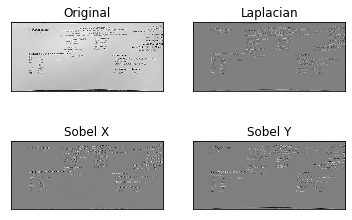

In [22]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# loading image
#img0 = cv2.imread('SanFrancisco.jpg',)
image = cv2.imread(r"C:\Users\malini.d\Desktop\Objectdetection\Scholar\research\object_detection\Test_images\IMG_20191220_111030.jpg")

# converting to gray scale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# remove noise
img = cv2.GaussianBlur(gray,(3,3),0)

# convolute with proper kernels
laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)  # x
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)  # y

plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()



In [24]:
image = cv2.imread(r"C:\Users\malini.d\Desktop\Objectdetection\Scholar\research\object_detection\Test_images\IMG_20191220_111030.jpg")
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.imread(r"C:\Users\malini.d\Desktop\Objectdetection\Scholar\research\object_detection\Test_images\IMG_20191220_111030.jpg",0)



(Text(0.5, 1.0, 'Sobel Y'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

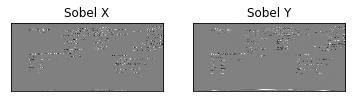

In [25]:
import cv2
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

image = cv2.imread(r"C:\Users\malini.d\Desktop\Objectdetection\Scholar\research\object_detection\Test_images\IMG_20191220_111030.jpg",0)
#load img in as grayscale

x_kernel = np.asarray([[-1, 0, 1], # Sobel kernel for x-direction
                      [-2, 0, 2],
                      [-1, 0, 1]])

y_kernel = np.asarray([[-1, -2, -1], # Sobel kernel for y-direction
                       [0,   0,  0],
                       [1,   2,  1]])
                      
sobel_x = signal.convolve2d(image, x_kernel) #
sobel_y = signal.convolve2d(image, y_kernel) # convolve kernels over images

plt.subplot(1,2,1), plt.imshow(sobel_x, cmap = 'gray') # Img with sobel-x
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(sobel_y, cmap = 'gray') # Img with sobel-y
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])


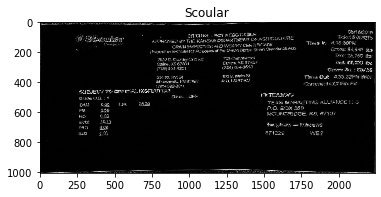

In [31]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Open the image
img = np.array(Image.open(r"C:\Users\malini.d\Desktop\Objectdetection\Scholar\research\object_detection\Test_images\IMG_20191220_111030.jpg")).astype(np.uint8)

# Apply gray scale
gray_img = np.round(0.299 * img[:, :, 0] +
                    0.587 * img[:, :, 1] +
                    0.114 * img[:, :, 2]).astype(np.uint8)

# Sobel Operator
h, w = gray_img.shape
# define filters
horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])  # s2
vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])  # s1

# define images with 0s
newhorizontalImage = np.zeros((h, w))
newverticalImage = np.zeros((h, w))
newgradientImage = np.zeros((h, w))

# offset by 1
for i in range(1, h - 1):
    for j in range(1, w - 1):
        horizontalGrad = (horizontal[0, 0] * gray_img[i - 1, j - 1]) + \
                         (horizontal[0, 1] * gray_img[i - 1, j]) + \
                         (horizontal[0, 2] * gray_img[i - 1, j + 1]) + \
                         (horizontal[1, 0] * gray_img[i, j - 1]) + \
                         (horizontal[1, 1] * gray_img[i, j]) + \
                         (horizontal[1, 2] * gray_img[i, j + 1]) + \
                         (horizontal[2, 0] * gray_img[i + 1, j - 1]) + \
                         (horizontal[2, 1] * gray_img[i + 1, j]) + \
                         (horizontal[2, 2] * gray_img[i + 1, j + 1])

        newhorizontalImage[i - 1, j - 1] = abs(horizontalGrad)

        verticalGrad = (vertical[0, 0] * gray_img[i - 1, j - 1]) + \
                       (vertical[0, 1] * gray_img[i - 1, j]) + \
                       (vertical[0, 2] * gray_img[i - 1, j + 1]) + \
                       (vertical[1, 0] * gray_img[i, j - 1]) + \
                       (vertical[1, 1] * gray_img[i, j]) + \
                       (vertical[1, 2] * gray_img[i, j + 1]) + \
                       (vertical[2, 0] * gray_img[i + 1, j - 1]) + \
                       (vertical[2, 1] * gray_img[i + 1, j]) + \
                       (vertical[2, 2] * gray_img[i + 1, j + 1])

        newverticalImage[i - 1, j - 1] = abs(verticalGrad)

        # Edge Magnitude
        mag = np.sqrt(pow(horizontalGrad, 2.0) + pow(verticalGrad, 2.0))
        newgradientImage[i - 1, j - 1] = mag

plt.figure()
plt.title('Scoular')
plt.imsave('Scoular.png', newgradientImage, cmap='gray', format='png')
plt.imshow(newgradientImage, cmap='gray')
plt.show()

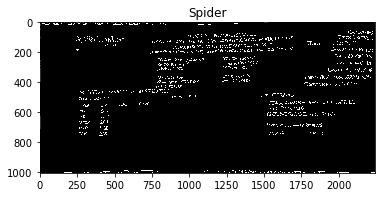

In [32]:
import cv2
import matplotlib.pyplot as plt

# Open the image
image = cv2.imread(r"C:\Users\malini.d\Desktop\Objectdetection\Scholar\research\object_detection\Test_images\IMG_20191220_111030.jpg")



# Apply Canny
edges = cv2.Canny(img, 100, 200, 3, L2gradient=True)

plt.figure()
plt.title('Spider')
plt.imsave('canny_detect.png', edges, cmap='gray', format='png')
plt.imshow(edges, cmap='gray')
plt.show()

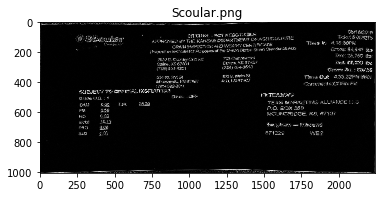

In [33]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Open the image
img = np.array(Image.open(r"C:\Users\malini.d\Desktop\Objectdetection\Scholar\research\object_detection\Test_images\IMG_20191220_111030.jpg")).astype(np.uint8)

# Apply gray scale
gray_img = np.round(0.299 * img[:, :, 0] +
                    0.587 * img[:, :, 1] +
                    0.114 * img[:, :, 2]).astype(np.uint8)

# Sobel Operator
h, w = gray_img.shape
# define filters
horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])  # s2
vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])  # s1

# define images with 0s
newhorizontalImage = np.zeros((h, w))
newverticalImage = np.zeros((h, w))
newgradientImage = np.zeros((h, w))

# offset by 1
for i in range(1, h - 1):
    for j in range(1, w - 1):
        horizontalGrad = (horizontal[0, 0] * gray_img[i - 1, j - 1]) + \
                         (horizontal[0, 1] * gray_img[i - 1, j]) + \
                         (horizontal[0, 2] * gray_img[i - 1, j + 1]) + \
                         (horizontal[1, 0] * gray_img[i, j - 1]) + \
                         (horizontal[1, 1] * gray_img[i, j]) + \
                         (horizontal[1, 2] * gray_img[i, j + 1]) + \
                         (horizontal[2, 0] * gray_img[i + 1, j - 1]) + \
                         (horizontal[2, 1] * gray_img[i + 1, j]) + \
                         (horizontal[2, 2] * gray_img[i + 1, j + 1])

        newhorizontalImage[i - 1, j - 1] = abs(horizontalGrad)

        verticalGrad = (vertical[0, 0] * gray_img[i - 1, j - 1]) + \
                       (vertical[0, 1] * gray_img[i - 1, j]) + \
                       (vertical[0, 2] * gray_img[i - 1, j + 1]) + \
                       (vertical[1, 0] * gray_img[i, j - 1]) + \
                       (vertical[1, 1] * gray_img[i, j]) + \
                       (vertical[1, 2] * gray_img[i, j + 1]) + \
                       (vertical[2, 0] * gray_img[i + 1, j - 1]) + \
                       (vertical[2, 1] * gray_img[i + 1, j]) + \
                       (vertical[2, 2] * gray_img[i + 1, j + 1])

        newverticalImage[i - 1, j - 1] = abs(verticalGrad)

        # Edge Magnitude
        mag = np.sqrt(pow(horizontalGrad, 2.0) + pow(verticalGrad, 2.0))
        newgradientImage[i - 1, j - 1] = mag

plt.figure()
plt.title('Scoular.png')
plt.imsave('Scoular_sobel.png', newgradientImage, cmap='gray', format='png')
plt.imshow(newgradientImage, cmap='gray')
plt.show()

# HED

In [41]:
image = cv2.imread(r'C:\Users\malini.d\Desktop\Edge_Detection\holistically-nested-edge-detection\images\IMG_20191220_111117.jpg')


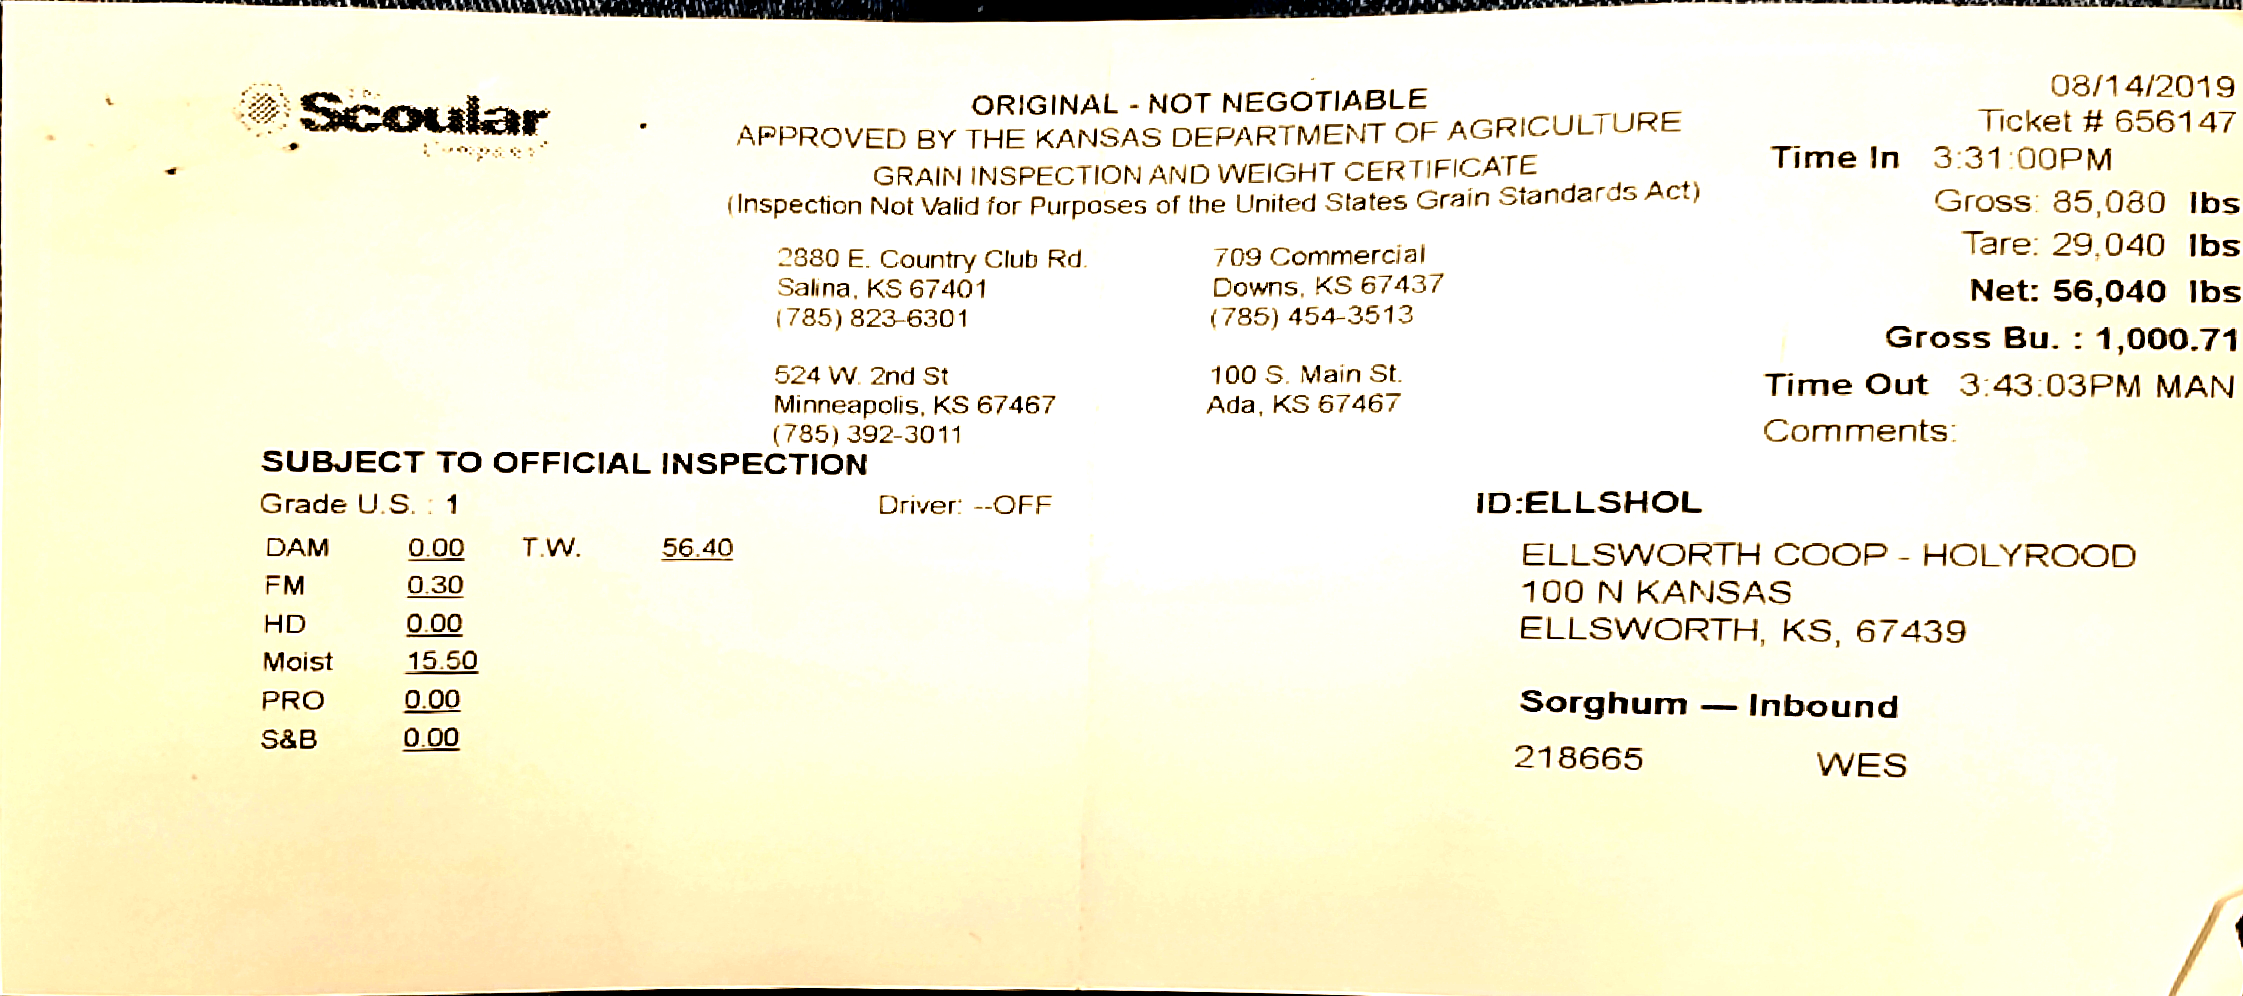

In [56]:
# Change contrast of image in PIL
def change_contrast(img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return img.point(contrast)

change_contrast(Image.open('IMG_20191220_111117.jpg'), 100)

In [60]:
from PIL import Image, ImageEnhance 
im = Image.open("IMG_20191220_111117.jpg")
enhancer = ImageEnhance.Sharpness(im)
enhanced_im = enhancer.enhance(10.0)
enhanced_im.save("enhanced.sample3.png")

In [24]:
(H, W) = image.shape[:2]
H

996

In [92]:
import cv2
img = cv2.imread("IMG_20191220_111117.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
b,g,r = cv2.split(img)
th, threshed1 = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
th, threshed2 = cv2.threshold(b, 100, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
cv2.imwrite("threshed_gray.png", threshed1)
cv2.imwrite("threshed_blue.png", threshed2)

True

In [93]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('IMG_20191220_111117.jpg',0)
ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)


cv2.imwrite("thresh1.jpg", thresh1)
cv2.imwrite("thresh2.jpg", thresh2)
cv2.imwrite("thresh3.jpg", thresh3)
cv2.imwrite("thresh4.jpg", thresh4)
cv2.imwrite("thresh5.jpg", thresh5)



True

In [5]:
import cv2 
import numpy as np
input_image = cv2.imread('IMG_20191220_111117.jpg', 0)
# image=imutils.resize(input_image,(800))
kernel = np.ones((3,3), np.uint8)       # set kernel as 3x3 matrix from numpy
#Create erosion and dilation image from the original image
erosion_image = cv2.erode(input_image, kernel, iterations=2)
dilation_image = cv2.dilate(input_image, kernel, iterations=1)
cv2.imwrite("erosion.jpg", erosion_image)

cv2.imshow('Input', input_image)
cv2.imshow('Erosion', erosion_image)
cv2.imshow('Dilation', dilation_image)
cv2.waitKey(0)

-1

In [108]:
dilation = cv2.dilate(input_image,kernel,iterations = 1)
cv2.imshow('Input', dilation)

In [17]:
from PIL import Image,ImageFilter
#Read image
im = Image.open('IMG_20191220_111117.jpg')
#Display image
im.show()

from PIL import ImageEnhance
enh = ImageEnhance.Contrast(im)
enh1=enh.enhance(100)
enh1.save('imageenh.jpg')

In [1]:
import cv2
import numpy as np

In [15]:
import imutils

#Load the image in grayscale
img = cv2.imread('IMG_20191220_111117.jpg',0)
image=imutils.resize(img,(3500))
#Threshold the image with threshold value 127
ret,image = cv2.threshold(image,175,250,0,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)

cv2.imwrite("threshold2.jpg", image)

cv2.imshow('Threshold', image)
cv2.waitKey(0)

-1

In [12]:
import numpy as np 
import cv2 
from matplotlib import pyplot as plt 
  
# Reading image from folder where it is stored 
img = cv2.imread('IMG_20191220_111117.jpg') 
  
# denoising of image saving it into dst image 
dst = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 15) 




# cv2.imshow('fastNlMeansDenoisingColored', dst)
# cv2.waitKey(0)

array([[[141, 156, 164],
        [ 80,  90,  95],
        [ 87,  98, 104],
        ...,
        [ 87,  91,  96],
        [123, 128, 134],
        [150, 156, 163]],

       [[148, 164, 172],
        [131, 145, 153],
        [141, 156, 164],
        ...,
        [ 89,  92,  98],
        [123, 128, 134],
        [150, 156, 163]],

       [[ 96, 108, 114],
        [141, 156, 164],
        [154, 170, 178],
        ...,
        [ 90,  94,  99],
        [125, 129, 136],
        [150, 156, 163]],

       ...,

       [[170, 194, 207],
        [168, 192, 205],
        [166, 190, 202],
        ...,
        [172, 195, 213],
        [172, 195, 213],
        [170, 193, 211]],

       [[172, 196, 209],
        [172, 196, 209],
        [170, 194, 207],
        ...,
        [172, 195, 213],
        [172, 195, 213],
        [170, 193, 211]],

       [[160, 184, 196],
        [159, 182, 194],
        [159, 182, 194],
        ...,
        [172, 195, 213],
        [172, 195, 213],
        [170, 193, 211]]

In [25]:
W

2243

In [ ]:
for img in img_list:
    image = cv2.imread(img)
    (H, W) = image.shape[:2]



    # convert the image to grayscale, blur it, and perform Canny
    # edge detection
    print("[INFO] performing Canny edge detection...")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blurred, 30, 150)

    # construct a blob out of the input image for the Holistically-Nested
    # Edge Detector
    blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(W, H),
        mean=(104.00698793, 116.66876762, 122.67891434),
        swapRB=False, crop=False)

    # set the blob as the input to the network and perform a forward pass
    # to compute the edges
    print("[INFO] performing holistically-nested edge detection...")
    net.setInput(blob)
    hed = net.forward()
    hed = cv2.resize(hed[0, 0], (W, H))
    hed = (255 * hed).astype("uint8")

    # show the output edge detection results for Canny and
    # Holistically-Nested Edge Detection
    cv2.imshow("Input", image)
    cv2.imshow("Canny", canny)
    cv2.imshow("HED", hed)
    cv2.waitKey(0)

In [34]:
import cv2
import os
import glob
img_dir = r'C:\Users\malini.d\Desktop\Edge_Detection\holistically-nested-edge-detection\images' # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
data = []
for img in files:
    image = cv2.imread(img)


In [40]:
(H, W) = image.shape[:2]
(H, W)

(500, 375)

In [103]:
print(image)
image.shape

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 89  61  50]
  [106  80  63]
  [116  91  71]
  ...
  [ 34  21  19]
  [ 27  15  13]
  [ 31  24  21]]

 [[178 153 133]
  [198 174 150]
  [180 157 131]
  ...
  [ 47  37  30]
  [ 39  28  24]
  [ 32  23  20]]

 [[223 198 172]
  [241 217 187]
  [229 206 174]
  ...
  [ 36  30  19]
  [ 54  42  38]
  [ 58  45  43]]]


(500, 375, 3)

In [111]:
img_list=os.listdir(r'C:\Users\malini.d\Desktop\Edge_Detection\holistically-nested-edge-detection\images')
print(img_list)

['cat.jpg', 'guitar.jpg', 'IMG_20191220_111117.jpg', 'janie.jpg']


In [113]:
image_length=len(img_list)

In [33]:
for img in img_list:
    image = cv2.imread(img)
    print(image)
#     

NameError: name 'img_list' is not defined

In [93]:
 print(img)

janie.jpg


# for object values

In [ ]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open("D:/projects_python/Escalon_Invoices/models/research/object_detection/test_images/32.jpg")
      image_np = load_image_into_numpy_array(image)
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
  objects = []
  threshold = 0.5 # in order to get higher percentages you need to lower this number; usually at 0.01 you get 100% predicted objects
  for index, value in enumerate(classes[0]):
    object_dict = {}
    if scores[0, index] > threshold:
        object_dict[(category_index.get(value)).get('name').encode('utf8')] = \
        scores[0, index]
        objects.append(object_dict)
  print (objects)

In [ ]:
len(objects)

In [ ]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    for image_path in TEST_IMAGE_PATHS:
      image = cv2.imread("D:/projects_python/Escalon_Invoices/models/research/object_detection/test_images/32.jpg")
      #image_np = load_image_into_numpy_array(image)
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})

          
      (frame_height, frame_width) = image.shape[:2]  
        
  objects = []
  threshold = 0.5 # in order to get higher percentages you need to lower this number; usually at 0.01 you get 100% predicted objects
  for index, value in enumerate(classes[0]):
    ymin = int((np.squeeze(boxes)[index][0]*frame_height))
    xmin = int((np.squeeze(boxes)[index][1]*frame_width))
    ymax = int((np.squeeze(boxes)[index][2]*frame_height))
    xmax = int((np.squeeze(boxes)[index][3]*frame_width))
    cropped_img = image[ymin:ymax,xmin:xmax]
    #cropped_img = cv2.resize(cropped_img, (0,0), fx = 3.0, fy = 3.0)
    #cropped_img=cv2.imread('img',cropped_img)
    #img = Image.fromarray(cropped_img, 'RGB')
    #text = pytesseract.image_to_string((cropped_img))
    #print(text)
cv2.imshow('cropped image', cropped_img)
cv2.waitKey(0)  
#           object_dict = {}
#           if scores[0, index] > threshold:
#               object_dict[(category_index.get(value)).get('name').encode('utf8')] = \
#                         scores[0, index]
#               objects.append(object_dict)
#     print (objects)
#               #print(len(np.where(scores[0] > threshold)[0])/num_detections[0])
#               #plt.figure(figsize=IMAGE_SIZE)
#     plt.imshow(image_np)

In [ ]:
use_normalized_coordinates

In [ ]:
import 

# resize

In [ ]:
import os
import cv2
#directory=r"D:\projects_python\Escalon_Invoices\models\research\object_detection\test_images\img.jpg"


#for img in os.listdir(directory):
file_name = r"D:/projects_python/prakesh/Invoices_F/FedEx/FedEx_Page_2.png"
img = cv2.imread(file_name)
im_resized = cv2.resize(img,(800,600))

cv2.imwrite(file_name,im_resized)

In [ ]:
file_name = r"D:/projects_python/prakesh/Invoices_F/FedEx/FedEx_Page_1.jpg"
file_name

In [ ]:
cv2.imshow('erg',img)
cv2.waitKey(0)

In [ ]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open("D:/projects_python/prakesh/Invoices - F/FedEx/FedEx_Page_1.jpg")
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8, min_score_thresh=.2)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)
plt.show()



# live cv2

In [ ]:
def run_inference_for_single_image(image, graph):
    if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        print(real_num_detection)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
        image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
        # Run inference
        output_dict = sess.run(tensor_dict,
                               feed_dict={image_tensor: np.expand_dims(image,0)})
        # all outputs are float32 numpy arrays, so convert types as appropriate
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        output_dict['detection_classes'] = output_dict[
            'detection_classes'][0].astype(np.unit8)
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]
        #print(output_dict['num_detections'])
        if 'detection_masks' in output_dict:
            output_dict['detection_masks'] = output_dict['detection_masks'][0]
        return output_dict

In [ ]:
import cv2
cap=cv2.VideoCapture(0)
try:
      with detection_graph.as_default():
            with tf.Session() as sess:
                # Get handles to input and output tensors
                ops = tf.get_default_graph().get_operations()
                all_tensor_names = {output.name for op in ops for output in op.outputs}
                tensor_dict = {}
                for key in [
                    'num_detections', 'detection_boxes', 'detection_scores',
                    'detection_classes', 'detection_masks'
                    ]:
                    tensor_name = key + ':0'
                    if tensor_name in all_tensor_names:
                        tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                            tensor_name)
                while True:
                    ret, image_np = cap.read()
                    cv2.imshow('imd',image_np)
                    image_np_expanded = np.expand_dims(image_np, axis=0)
                    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
                    vis_util.visualize_boxes_and_labels_on_image_array(
                        image_np,
                        output_dict['detection_boxes'],
                        output_dict['detection_classes'],
                        output_dict['detection_scores'],
                        category_index,
                        instance_masks=output_dict.get('detection_masks'),
                        use_normalized_coordinates=True,
                        line_thickness=8)
                    cv2.imshow('object_detection',cv2.resize(image_np,(800,600)))
                    if cv2.waitKey(0) & 0xFF == ord('q'):
                        #cap.release()
                        cv2.destroyAllWindows()
                        break
except Exception as e:
    print(e)
    cap.release()
                    
                
                        
     

In [ ]:
image = Image.open("D:/projects_python/Escalon_Invoices/models/research/object_detection/test_images/32.jpg")
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
#print(output_dict['detection_boxes'])
    
#plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)
plt.show()

In [1]:
saved_model_dir=r'C:\Users\malini.d\Desktop\Objectdetection\Scholar\research\object_detection\faster_rcnn_inception_v2_coco_2018_01_28\saved_model'

In [2]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:The specified SavedModel has no variables; no checkpoints were restored.
INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}
INFO:tensorflow:input tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: inputs
INFO:tensorflow: tensor name: image_tensor:0, shape: (-1, -1, -1, 3), type: DT_UINT8
INFO:tensorflow:output tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: detection_scores
INFO:tensorflow: tensor name: detection_scores:0, shape: (-1, 100), type: DT_FLOAT
INFO:tensorflow:Tensor's key in saved_model's tensor_map: detection_clas

ValueError: None is only supported in the 1st dimension. Tensor 'image_tensor' has invalid shape '[None, None, None, 3]'.